# Imports

In [1]:
import pandas
import os
import itertools
import random
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import copy
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import cv2
from torchvision.datasets import ImageFolder

# Part 1

## Part 1.1

In [2]:
from styles import styles, styles_count

In [3]:
styles

{'прическа': ['нет волос',
  'длинные в пучок',
  'длинные волнистые',
  'длинные прямые',
  'короткая волнистые',
  'короткая прямые',
  'короткая курчавые'],
 'цвет волос': ['черный',
  'блонд',
  'каштановый',
  'пастельный розовый',
  'рыжий',
  'серебристо серый'],
 'аксесуар': ['нет очков', 'круглые очки', 'солнцезащитные очки'],
 'одежда': ['худи',
  'комбинезон',
  'футболка с круглым вырезом',
  'футболка с V-вырезом'],
 'цвет одежды': ['черный',
  'синий',
  'серый',
  'зеленый',
  'оранжевый',
  'розовый',
  'красный',
  'белый']}

In [4]:
styles_count

{'прическа': [7, 0, 1, 23, 1, 11, 7],
 'цвет волос': [7, 6, 2, 3, 8, 24],
 'аксесуар': [11, 22, 17],
 'одежда': [7, 18, 19, 6],
 'цвет одежды': [4, 5, 6, 8, 6, 8, 7, 6]}

In [5]:
def get_random_style(styles, styles_count):
    all_combs = []
    features_and_probs = copy.deepcopy(styles)
    for x in styles:
        for y in range(len(styles[x])):
            features_and_probs[x][y] = [
                styles[x][y],
                (styles_count[x][y] + 1)
                / (sum(styles_count[x]) + len(styles_count[x])),
            ]
    all_combs = list(itertools.product(*features_and_probs.values()))
    styles_and_prob = []
    for x in all_combs:
        pr = 1
        for _ in x:
            pr *= _[1]
        style_and_prob = {"style": [_[0] for _ in x], "prob": pr}
        styles_and_prob.append(style_and_prob)
    probs = [x["prob"] for x in styles_and_prob]
    return random.choices(styles_and_prob, probs)

In [6]:
def get_all_probs(styles, styles_count):
    features_and_probs = copy.deepcopy(styles)
    for x in styles:
        for y in range(len(styles[x])):
            features_and_probs[x][y] = [
                styles[x][y],
                (styles_count[x][y] + 1)
                / (sum(styles_count[x]) + len(styles_count[x])),
            ]
    all_combs = list(itertools.product(*features_and_probs.values()))
    styles_and_prob = []
    for x in all_combs:
        pr = 1
        for _ in x:
            pr *= _[1]
        style_and_prob = {"style": [_[0] for _ in x], "prob": pr}
        styles_and_prob.append(style_and_prob)
    return styles_and_prob

In [7]:
get_random_style(styles, styles_count)

[{'style': ['длинные прямые',
   'рыжий',
   'нет очков',
   'футболка с круглым вырезом',
   'зеленый'],
  'prob': 0.0008805357570895357}]

In [8]:
get_all_probs(styles, styles_count)

[{'style': ['нет волос', 'черный', 'нет очков', 'худи', 'черный'],
  'prob': 5.797766301824104e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'синий'],
  'prob': 6.957319562188924e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'серый'],
  'prob': 8.116872822553745e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'зеленый'],
  'prob': 0.00010435979343283386},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'оранжевый'],
  'prob': 8.116872822553745e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'розовый'],
  'prob': 0.00010435979343283386},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'красный'],
  'prob': 9.276426082918565e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'худи', 'белый'],
  'prob': 8.116872822553745e-05},
 {'style': ['нет волос', 'черный', 'нет очков', 'комбинезон', 'черный'],
  'prob': 0.00013769694966832247},
 {'style': ['нет волос', 'черный', 'нет очков', 'комбинезон', 'синий'],
  'prob

## Part 1.2

In [9]:
avatars_dir = "/home/mike/python_files/deep_generative_models/2024_deep_gen_models/HW_1.Bias_gen_and_autoencoders/avatars"
images_names = os.listdir(avatars_dir)

In [10]:
def get_probs_of_pixels(directory):
    images_names = os.listdir(avatars_dir)
    image_np = cv2.cvtColor(
        cv2.imread(os.path.join(avatars_dir, images_names[1])),
        cv2.COLOR_RGB2BGR,
    )
    probs_of_ppx = np.empty(image_np.shape).tolist()
    for x in range(len(probs_of_ppx)):
        for y in range(len(probs_of_ppx[x])):
            probs_of_ppx[x][y] = {}
    for image_name in images_names:
        image_np = cv2.cvtColor(
            cv2.imread(os.path.join(avatars_dir, image_name)),
            cv2.COLOR_RGB2BGR,
        )
        for y in range(image_np.shape[0]):
            for x in range(image_np.shape[1]):
                px_color = ",".join(map(str, image_np[y][x].tolist()))
                if px_color in probs_of_ppx[y][x]:
                    probs_of_ppx[y][x][px_color] += 1
                else:
                    probs_of_ppx[y][x][px_color] = 1
    for x in range(len(probs_of_ppx)):
        for y in range(len(probs_of_ppx[x])):
            for px_color in probs_of_ppx[x][y].keys():
                if probs_of_ppx[x][y][px_color] == 0:
                    probs_of_ppx[x][y][px_color] = 1
                probs_of_ppx[x][y][px_color] = probs_of_ppx[x][y][
                    px_color
                ] / len(images_names)
    return probs_of_ppx

In [11]:
def get_random_style(probs_of_ppx=None):
    if probs_of_ppx is None:
        probs_of_ppx = get_probs_of_pixels(avatars_dir)
    new_avatar = np.empty([len(probs_of_ppx), len(probs_of_ppx[0]), 3])
    for x in range(len(probs_of_ppx)):
        for y in range(len(probs_of_ppx[x])):
            new_avatar[x][y] = list(
                map(
                    int,
                    random.choices(
                        list(probs_of_ppx[x][y].keys()),
                        probs_of_ppx[x][y].values(),
                    )[0].split(","),
                )
            )
    return np.array(new_avatar).astype(int)

In [12]:
probs_of_ppx = get_probs_of_pixels(avatars_dir)
get_random_style(probs_of_ppx=probs_of_ppx)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

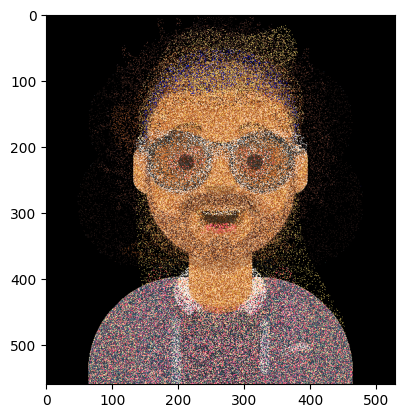

In [13]:
new_avatar1 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar1)
plt.savefig(
    "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/gen_avatars/avatar1.png"
)

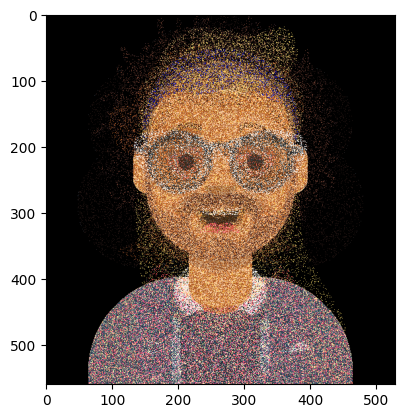

In [14]:
new_avatar2 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar2)
plt.savefig(
    "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/gen_avatars/avatar2.png"
)

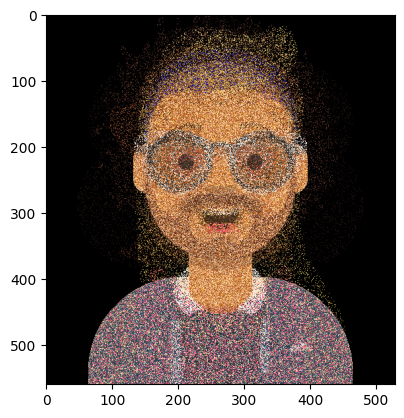

In [15]:
new_avatar3 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar3)
plt.savefig(
    "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/gen_avatars/avatar3.png"
)

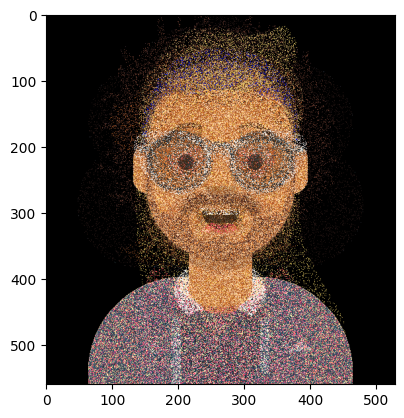

In [16]:
new_avatar4 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar4)
plt.savefig(
    "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/gen_avatars/avatar4.png"
)

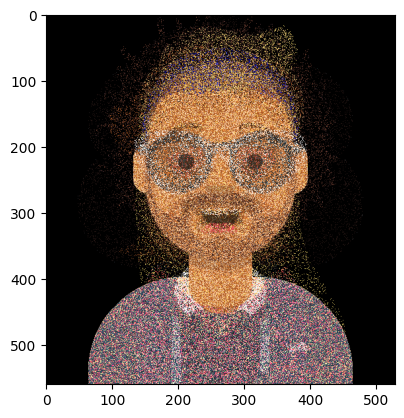

In [17]:
new_avatar5 = get_random_style(probs_of_ppx)
plt.imshow(new_avatar5)
plt.savefig(
    "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/gen_avatars/avatar5.png"
)

In [18]:
(new_avatar4 == new_avatar4).sum() / (528 * 560 * 3)

1.0

In [19]:
(new_avatar4 == new_avatar5).sum() / (528 * 560 * 3)

0.5828564664502165

Очень похожи, потому что выборка маленькая, всего 11 аватаров

# Part 2

## Imports and vars

In [21]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
from torchvision.datasets import ImageFolder

from sklearn.metrics import f1_score, precision_score, recall_score

In [22]:
images_dir_train = "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/dataset/train"
images_dir_test = "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/dataset/test/imgs"
images_dir_proliv = "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/dataset/proliv"
val_ann_file = "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/dataset/val_ann.txt"
test_ann_file = "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/dataset/test/test_annotation.txt"
images_abs_dir = "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/dataset/train/class1"
image_names = os.listdir(images_abs_dir)

## Train

In [23]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, code_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, code_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, input_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
class Autoencoder_CNN(nn.Module):
    def __init__(self, input_dim, code_dim):
        super(Autoencoder_CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 4, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4, code_dim, 4, stride=1, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(code_dim, 4, 4, stride=1, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                8, 16, 3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                16, input_dim, 3, stride=2, padding=1, output_padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
img_tmp = cv2.cvtColor(
    cv2.imread(os.path.join(images_abs_dir, image_names[35])),
    cv2.COLOR_RGB2BGR,
)
Image.fromarray(img_tmp)

In [26]:
img_tmp.shape

(25, 46, 3)

In [27]:
numSamples = len(image_names)
mean = np.array([0.0, 0.0, 0.0])
stdTemp = np.array([0.0, 0.0, 0.0])
std = np.array([0.0, 0.0, 0.0])
for i in range(numSamples):
    im = cv2.imread(os.path.join(images_abs_dir, image_names[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.0

    for j in range(3):
        mean[j] += np.mean(im[:, :, j])

mean = mean / numSamples

for i in range(numSamples):
    im = cv2.imread(os.path.join(images_abs_dir, image_names[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.0
    for j in range(3):
        stdTemp[j] += ((im[:, :, j] - mean[j]) ** 2).sum() / (
            im.shape[0] * im.shape[1]
        )

std = np.sqrt(stdTemp / numSamples)

print(mean)
print(std)

[0.42337907 0.53418146 0.46204374]
[0.04698288 0.05217051 0.04838507]


In [28]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [29]:
trainset = ImageFolder(images_dir_train, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

In [30]:
input_dim = 32 * 32 * 3
input_dim_cnn = 3
code_dim = 16
model = Autoencoder(input_dim, code_dim)
# model = Autoencoder_CNN(input_dim_cnn, code_dim)

In [31]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005)

In [33]:
best_loss = None
for epoch in range(50):
    for data in trainloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if best_loss is None:
        best_loss = loss.item()
    if loss.item() <= best_loss:
        torch.save(
            model.state_dict(),
            # "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/model_cnn.pth",
            "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/model.pth",
        )
        best_loss = loss.item()
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.4614957869052887
Epoch: 1, Loss: 0.4462393522262573
Epoch: 2, Loss: 0.3274562656879425
Epoch: 3, Loss: 0.2816530168056488
Epoch: 4, Loss: 0.2345041185617447
Epoch: 5, Loss: 0.4169696569442749
Epoch: 6, Loss: 0.17813174426555634
Epoch: 7, Loss: 0.3409860134124756
Epoch: 8, Loss: 0.21288736164569855
Epoch: 9, Loss: 0.25650694966316223
Epoch: 10, Loss: 0.18668057024478912
Epoch: 11, Loss: 0.22647078335285187
Epoch: 12, Loss: 0.1861388236284256
Epoch: 13, Loss: 0.2785433828830719
Epoch: 14, Loss: 0.2785245478153229
Epoch: 15, Loss: 0.2818583548069
Epoch: 16, Loss: 0.33010244369506836
Epoch: 17, Loss: 0.22921103239059448
Epoch: 18, Loss: 0.26883989572525024
Epoch: 19, Loss: 0.19413018226623535
Epoch: 20, Loss: 0.25796762108802795
Epoch: 21, Loss: 0.15561443567276
Epoch: 22, Loss: 0.22315062582492828
Epoch: 23, Loss: 0.18859268724918365
Epoch: 24, Loss: 0.18469490110874176
Epoch: 25, Loss: 0.15879803895950317
Epoch: 26, Loss: 0.2543347477912903
Epoch: 27, Loss: 0.2133485078

In [34]:
best_loss

0.135118305683136

## Val and threshold set

In [35]:
print(os.listdir("/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/dataset/test/imgs"))

['9987b102-fd10-428e-becc-c7c3194a9866.jpg', '6fde8076-0a6d-4422-a7d4-f917db56127d.jpg', '5adc44f9-78b5-40b2-bc1f-a3bf5ef521a3.jpg', 'a8e67ff9-74b0-4af6-8553-bf4c1565af2c.jpg', 'af552a9b-b2d1-447b-86b9-c658632d4687.jpg', 'fe91cf3f-5224-48ae-a3a9-1d4004b1d412.jpg', '04e826fe-11f0-4616-b4b2-d467f5f9cb1b.jpg', 'e20f590d-199c-49cf-a87e-19e7b0f53b64.jpg', '41b2b013-e077-4cfd-8a98-af58da47b72b.jpg', '843a4611-d5de-43bb-aba1-137c8f2e13db.jpg', '1ecfeb59-e96c-48da-b546-4b6d2df1b976.jpg', '7a33d8d1-ad24-49ab-a536-d7719ddee299.jpg', 'f6b9ddbe-064d-440d-b298-fb1346969978.jpg', 'd05e5345-e88a-439e-b7f8-39437d0d3dc2.jpg', 'ffd610b0-4250-434f-8293-81176a990be9.jpg', '2384aaf9-14e8-454e-b7ee-ea2f2428a951.jpg', '47d8bea2-013e-4c16-be43-9e83e346d242.jpg', 'cce2fd75-36a0-42aa-9850-4744a9df9afd.jpg', '3c7ad042-e709-4013-aa10-9ab0dfa5148f.jpg', '1eb0ae70-80ee-4a00-9a57-f8496ec0d46d.jpg', '7ddd83a0-a0c4-470c-aa03-bdaf67476332.jpg', '3239ed6c-e416-4fc4-95c6-e42b50c248ce.jpg', '920147fd-a28b-4167-85bb-73f56b

In [36]:
with open(val_ann_file, "w") as ann_file:
    for x in os.listdir(images_dir_proliv):
        print(
            os.path.join(images_dir_proliv, x), 1, file=ann_file, sep=";"
        )
    for x in os.listdir(images_abs_dir):
        print(
            os.path.join(images_abs_dir, x), 0, file=ann_file, sep=";"
        )

In [37]:
val_results = {"proliv": [], "normal": []}

In [38]:
model.load_state_dict(
    torch.load(
        "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/model.pth"
    )
)
with open(val_ann_file, "r") as ann_file:
    for x in ann_file:
        img_path, img_tag = x.split(";")[0], int(x.split(";")[1])
        test_image = Image.open(img_path)
        test_image = transform(test_image)
        test_image = test_image.unsqueeze(0)
        test_image = test_image.view(test_image.size(0), -1)
        output = model(test_image)
        mse = criterion(output, test_image)
        if img_tag==0:
            val_results["normal"].append(mse.item())
        else:
            val_results["proliv"].append(mse.item())

In [39]:
np.median(np.array(val_results["proliv"]))

1.399657428264618

In [40]:
np.median(np.array(val_results["normal"]))

0.13602282851934433

In [41]:
proliv_threshold = (
    np.median(np.array(val_results["proliv"]))
    + np.median(np.array(val_results["normal"]))
) / 2
proliv_threshold = (
    np.array(val_results["proliv"]).mean()
    + np.array(val_results["normal"]).mean()
) / 2
proliv_threshold

0.8347766467469442

## Test

In [42]:
def get_tag_of_img(
    test_image_path,
    model_path,
    threshold,
    transforms,
    input_dim=32 * 32 * 3,
    code_dim=16,
    model=None,
):
    if model is None:
        model = Autoencoder(input_dim, code_dim)
        model.load_state_dict(torch.load(model_path))
    test_image = Image.open(test_image_path)
    test_image = transforms(test_image)
    test_image = test_image.unsqueeze(0)
    test_image = test_image.view(test_image.size(0), -1)
    output = model(test_image)
    mse = criterion(output, test_image)
    if mse.item() <= threshold:
        return 0
    else:
        return 1

In [43]:
test_results = []
pred = []
gt = []

In [44]:
model = Autoencoder(input_dim, code_dim)
model.load_state_dict(torch.load("/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/model.pth"))


with open(test_ann_file, "r") as ann_file:
    for x in ann_file:
        img_path, img_tag = os.path.join(
            images_dir_test, " ".join(x.split(" ")[:-1])
        ), int(x.split(" ")[1])
        gt.append(img_tag)
        pred.append(get_tag_of_img(img_path, "/home/mike/python_files/deep_generative_models/deep_generative_models/HW1/model.pth", proliv_threshold, transform, model=model))

In [45]:
print("Precision", precision_score(gt, pred))
print("F1_score", f1_score(gt, pred))
print("Recall", recall_score(gt, pred))
print("TPR", recall_score(gt, pred, pos_label=1))
print("TNR", recall_score(gt, pred, pos_label=0))


Precision 0.1644021739130435
F1_score 0.2797687861271676
Recall 0.937984496124031
TPR 0.937984496124031
TNR 0.8321964529331515
